# Amortized Inference for a NLME Model

## Simulation & Training Phase

In [1]:
from time import perf_counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from bayesflow.simulation import GenerativeModel
from bayesflow import diagnostics

/Users/jonas.arruda/miniconda/envs/Amortized-NLME/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
model_name = ['fröhlich-simple', 'fröhlich-detailed', 'fröhlich-sde',
              'pharmacokinetic_model', 'dePillis'][-1]
if model_name == 'fröhlich-detailed' or model_name == 'pharmacokinetic_model' or 'dePillis' in model_name:
    # this is needed so julia is recognized correctly
    from juliacall import Main as jl

# specify which model to use
network_idx = 3
load_best_network = False

In [3]:
# show or save plots
show_plots = True
save_plots = False
    
# training params
early_stopping = True  # if training should be stopped if no improvement on a validation set can be seen
presimulate = False  # if simulations should be generated before or while training of the neural networks
train_network = False  # if neural networks should be trained or only load (already trained) networks

## Load model

To train your own model you should define 
```
def batch_simulator(param_samples: np.ndarray, other_args) -> np.ndarray:
```
which takes in parameters in the form of (#simulations, #parameters) and a model-class of the form

```
class myModel(NlmeBaseAmortizer):
    def __init__(self, name: str = 'myModel'):
        # define names of parameters
        param_names = ['name1', 'name2']

        # define prior values (for log-parameters)
        prior_mean = np.array([0, 0])
        prior_cov = np.diag([1, 1])
        self.prior_type = 'normal'

        super().__init__(name=name,
                         param_names=param_names,
                         prior_mean=prior_mean,
                         prior_cov=prior_cov)

        self.simulator = Simulator(batch_simulator_fun=partial(batch_simulator,
                                                                  other_args=other_args))
```
where you specify your parameters, a parameter-prior on the individual level (standard is normal distribution) and connect your `batch_simulator` to the model.

In this notebook, the example models are loaded from an external file, where each model defines its own `batch_simulator` function, which is used to generate simulations and some other further helper function to generate plots etc.

In [4]:
presimulation_path = '../data/'

if model_name == 'fröhlich-simple':
    from models.froehlich_model_simple import FroehlichModelSimple
    model = FroehlichModelSimple(network_idx=network_idx, load_best=load_best_network)
    
    use_presimulation = False
elif model_name == 'fröhlich-detailed':
    from models.froehlich_model_detailed import FroehlichModelDetailed
    model = FroehlichModelDetailed(network_idx=network_idx, load_best=load_best_network)

    use_presimulation = True
    presimulation_path += 'presimulations_froehlich_detailed'

elif model_name == 'fröhlich-sde':
    from models.froehlich_model_sde import FroehlichModelSDE
    model = FroehlichModelSDE(network_idx=network_idx, load_best=load_best_network)

    use_presimulation = True
    presimulation_path += 'presimulations_froehlich_sde'
    
elif model_name == 'pharmacokinetic_model':
    from models.pharmacokinetic_model import PharmacokineticModel
    model = PharmacokineticModel(network_idx=network_idx, load_best=load_best_network)
    
    use_presimulation = True
    presimulation_path += 'presimulations_pharma'
    
elif model_name == 'dePillis':
    from models.de_pillis_model import dePillisModel
    model = dePillisModel(network_idx=network_idx, load_best=load_best_network)

    use_presimulation = True
    presimulation_path += 'presimulations_de_pillis'
else:
    raise NotImplementedError('model not implemented')

  Activating project at `~/PyCharm Projects/Amortized-NLME-Models/models/SimulatorDePillis`


using 2 layers of MultiConv1D, a bidirectional LSTM with 32 units and a dense layer with output dimension 18 as summary network
using a 7-layer cINN as inference network with 3 layers of design spline
Using de Pillis prior
prior mean: [  2.30258509  -4.60517019  -0.69314718 -11.51292546 -11.51292546
   2.30258509   4.00733319  -2.30258509  -2.30258509]
prior covariance diagonal: [5. 5. 5. 5. 5. 3. 3. 1. 1.]
Using the model dePillisModel


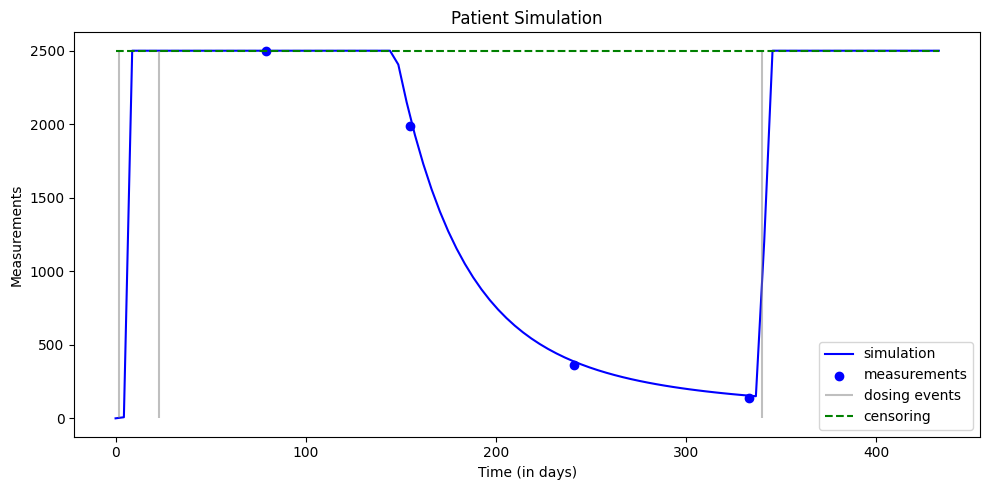

In [8]:
if show_plots:
    # the example models all support this function (which is optional)
    model.plot_example()

In [9]:
# example training
max_epochs = 1
iterations_per_epoch = 10

In [10]:
if presimulate:
    # if you want to generate simulations before training use this code block
    generative_model = GenerativeModel(model.prior, model.simulator)
    start_time = perf_counter()
    np.random.seed(42)
    generative_model.presimulate_and_save(batch_size=128, 
                                          folder_path=presimulation_path,
                                          iterations_per_epoch=iterations_per_epoch,
                                          epochs=max_epochs,
                                          disable_user_input=True)
    end_time = perf_counter()
    print(f'simulation time: {(end_time-start_time)/60} minutes')

## Training

In [11]:
# create your neural amortizer, the class NlmeBaseAmortizer predefines a network
# if you want to change the network architecture, check out the examples in the function 'load_amortizer_configuration' in one of the models classes 
# you can change summary and inference network to a wide range of architectures
trainer = model.build_trainer('../networks/' + model.network_name)
print(model.network_name)

INFO:root:Performing 2 pilot runs with the dePillisModel model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 9)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 7, 3)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Loaded loss history from ../networks/amortizer-dePillis-normal-sequence-summary-Bi-LSTM-7layers-3coupling-spline-300epochs_normal/history_238.pkl.
INFO:root:Networks loaded from ../networks/amortizer-dePillis-normal-sequence-summary-Bi-LSTM-7layers-3coupling-spline-300epochs_normal/ckpt-238
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


Model: "amortized_posterior"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Invert  multiple                  902923    
 ibleNetwork)                                                    
                                                                 
 sequence_network (Sequence  multiple                  25458     
 Network)                                                        
                                                                 
Total params: 928381 (3.54 MB)
Trainable params: 928255 (3.54 MB)
Non-trainable params: 126 (504.00 Byte)
_________________________________________________________________
None
amortizer-dePillis-normal-sequence-summary-Bi-LSTM-7layers-3coupling-spline-300epochs_normal


each epoch a number of iterations each with batch_size many simulations is performed

In [12]:
history = {}
if train_network and not use_presimulation:
    # online training: simulation is done whenever needed
    start_time = perf_counter()
    history = trainer.train_online(epochs=max_epochs,
                                  iterations_per_epoch=iterations_per_epoch,
                                  batch_size=128,
                                  early_stopping=early_stopping,
                                  validation_sims=iterations_per_epoch)
    end_time = perf_counter()
    print(f'training time: {(end_time-start_time)/60} minutes')

In [13]:
if train_network and use_presimulation:
    # prepare optimizer for offline training (simulations were done before training)
    trainer._setup_optimizer(optimizer=None,
                             epochs=max_epochs,
                             iterations_per_epoch=iterations_per_epoch)

In [14]:
if train_network and use_presimulation:
    # simulation done before, start training now
    start_time = perf_counter()
    history = trainer.train_from_presimulation(presimulation_path=presimulation_path,
                                               optimizer=trainer.optimizer,
                                               max_epochs=max_epochs,
                                               early_stopping=early_stopping,
                                               #custom_loader=custom_loader if model_name == 'dePillis' else None,
                                               validation_sims=iterations_per_epoch)

    end_time = perf_counter()
    print(f'training time: {(end_time-start_time)/60} minutes')
else:
    trainer.load_pretrained_network()
    history = trainer.loss_history.get_plottable()

In [15]:
# Check if training converged
if np.isnan(history['val_losses'].iloc[-1]).any():
    print('Training failed with NaN loss at the end')
    if np.isnan(history['val_losses'].iloc[-7:]).all():
        print('Training failed with NaN loss for all latest checkpoints')

# Find the checkpoint with the lowest validation loss out of the last 7
recent_losses = history['val_losses'].iloc[-7:]
best_valid_epoch = recent_losses['Loss'].idxmin() + 1  # checkpoints are 1-based indexed
new_checkpoint = trainer.manager.latest_checkpoint.rsplit('-', 1)[0] + f'-{best_valid_epoch}'    
trainer.checkpoint.restore(new_checkpoint)
print("Networks loaded from {}".format(new_checkpoint))
print("Validation loss: {:.4f}".format(recent_losses['Loss'].min()))

Networks loaded from ../networks/amortizer-dePillis-normal-sequence-summary-Bi-LSTM-7layers-3coupling-spline-300epochs_normal/ckpt-237
Validation loss: 9.7415


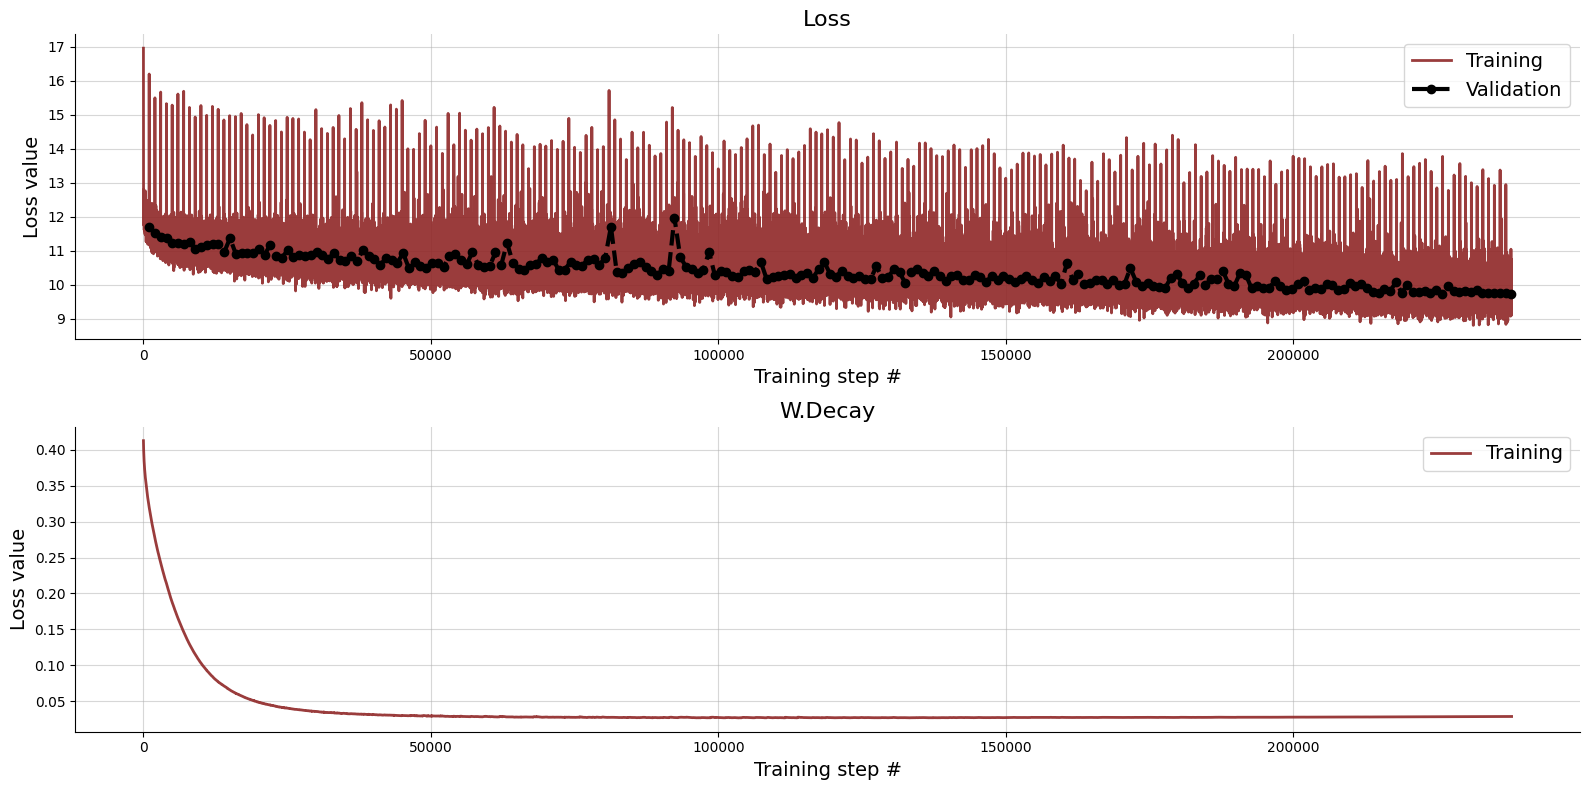

In [16]:
# show training loss
fig_losses = diagnostics.plot_losses(history['train_losses'], val_losses=history['val_losses']);

100%|██████████| 25/25 [00:13<00:00,  1.82it/s]


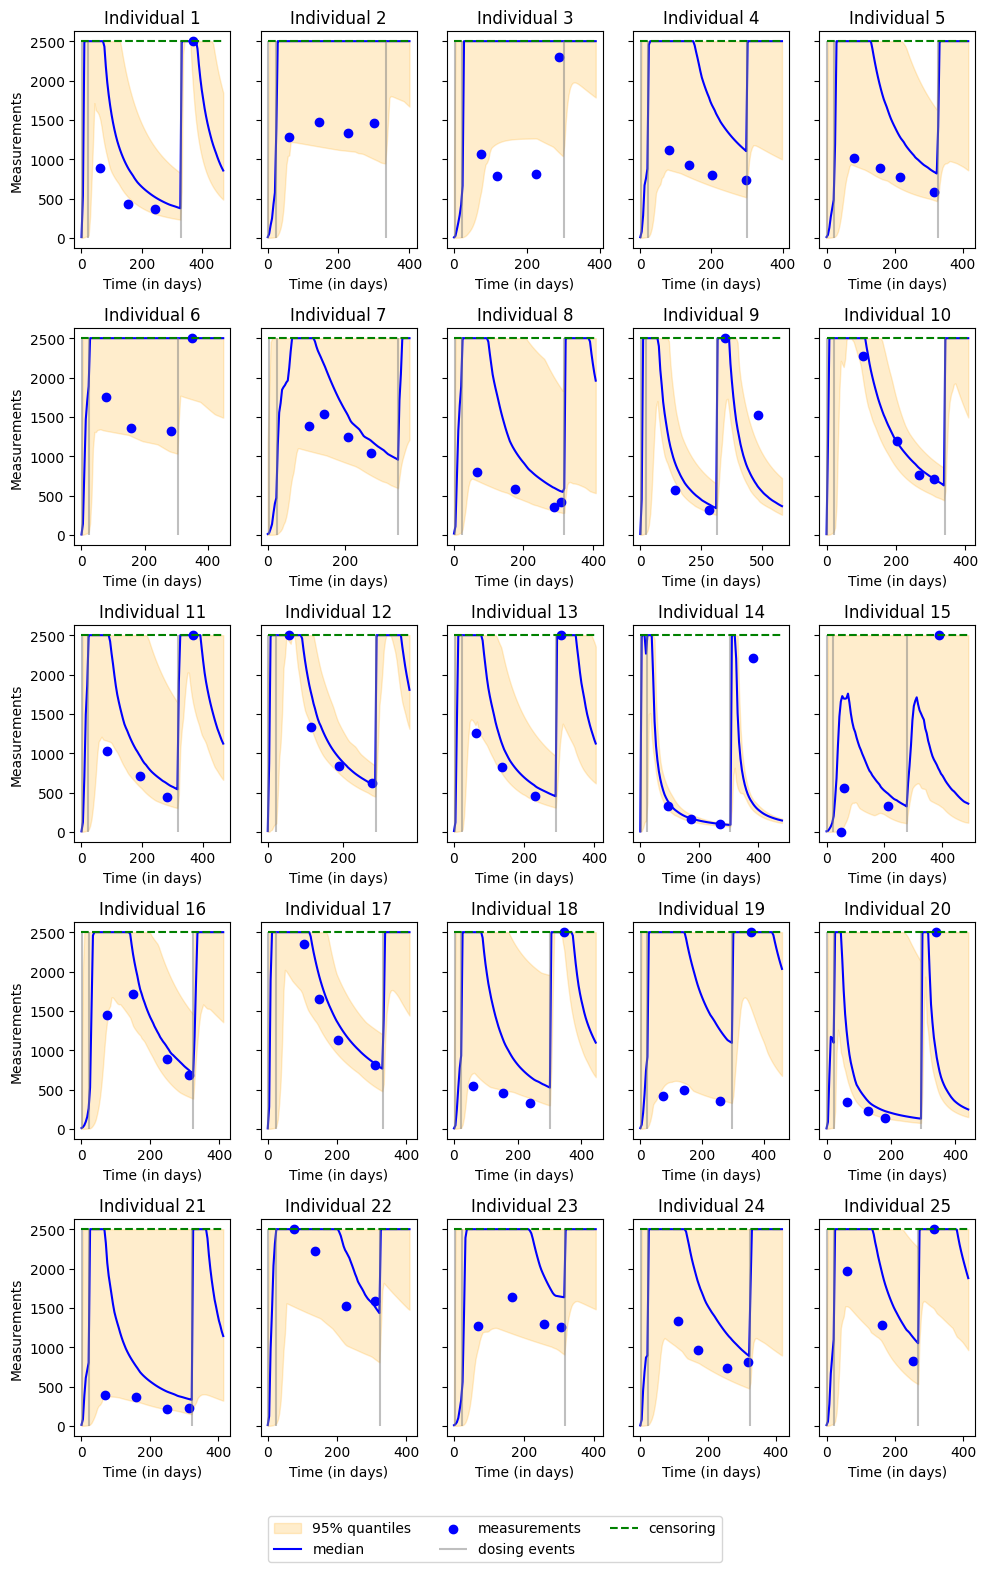

In [17]:
# load real data (here for the first time), simulate posterior and plot
test_data = model.load_data(n_data=25, synthetic=False)  # or load synthetic data with synthetic=True
data_posterior_draws = model.draw_posterior_samples(data=test_data, n_samples=100)

rows = 5
fig, ax = plt.subplots(rows, int(np.ceil(len(test_data) / rows)), tight_layout=True, 
                       figsize=(10, rows*3), sharey='row')
axis = ax.flatten()
    
for p_id in tqdm(range(len(test_data))):
    axis[p_id] = model.prepare_plotting(test_data[p_id], data_posterior_draws[p_id], axis[p_id])
    _, labels = axis[p_id].get_legend_handles_labels()
    axis[p_id].set_title(f'Individual {p_id+1}')
    if p_id % rows != 0:
        axis[p_id].set_ylabel('')

fig.legend(labels, ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.01))
if save_plots:
    fig.savefig(f'../plots/calibration/{model_name}/{model.network_name}_fit.png')
plt.show()

## Validate Posteriors using SBC-Plots

To check if the training converged, you should validate the posteriors using the following visual diagnostics.
If you want, you can also compare the posteriors to any other method (like MCMC or ABC). Check out the "Validate Posterior with MCMC"-notebook in the Experiments folder for a comparison to MCMC.

In [18]:
new_sims = model.generate_simulations_from_prior(trainer=trainer, n_samples=2500)
posterior_draws = model.draw_posterior_samples(data=new_sims['summary_conditions'], n_samples=100)

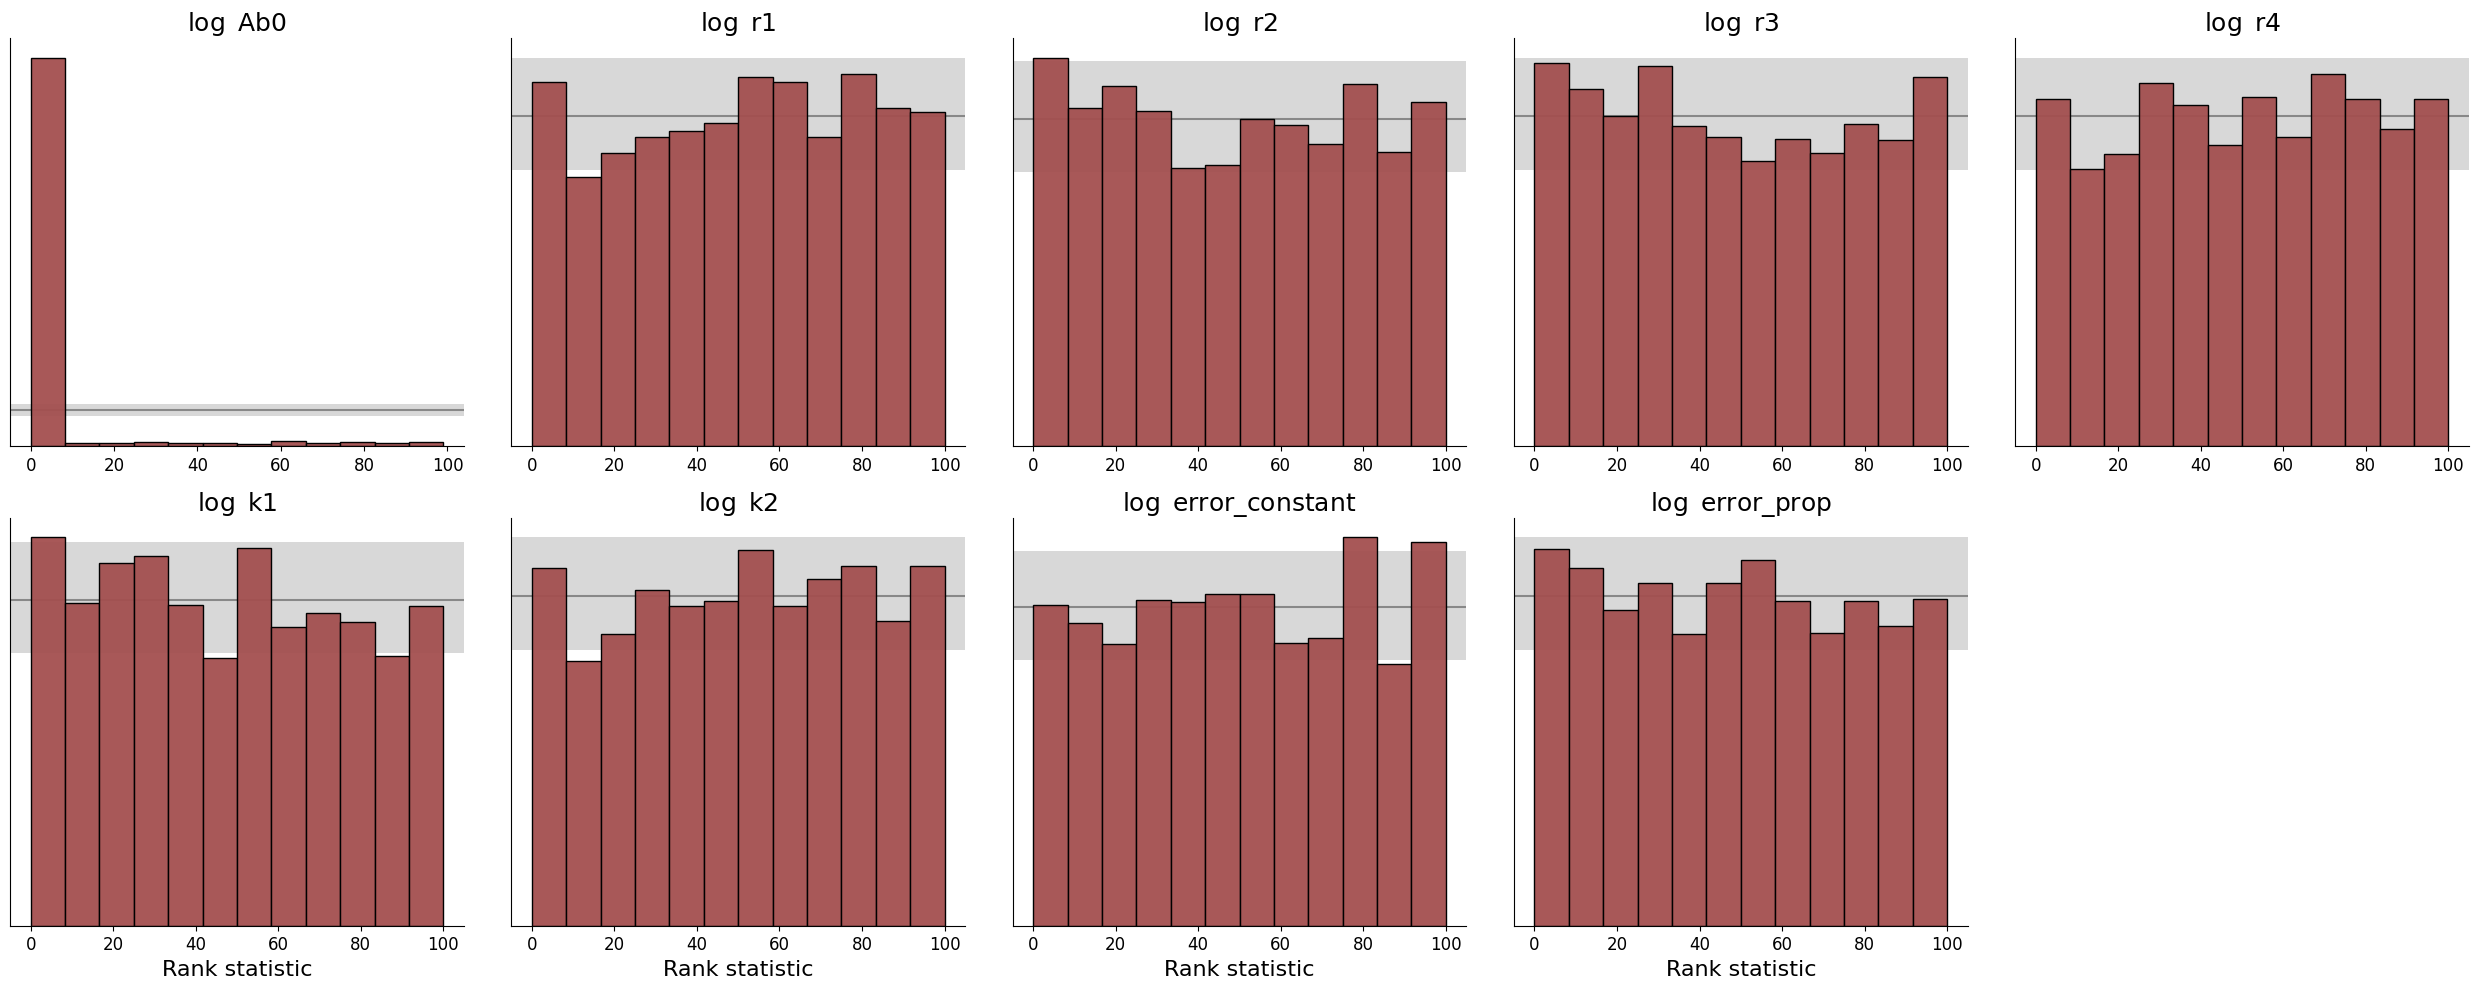

In [19]:
fig_sbc = diagnostics.plot_sbc_histograms(post_samples=posterior_draws,
                                          prior_samples=new_sims['parameters'],
                                          param_names=model.log_param_names)

for _ax in fig_sbc.axes[model.n_params:]:  
    _ax.remove()  # TODO: this is a bug in BayesFlow, figure should be cleaned already
if save_plots:
    fig_sbc.savefig(f'../plots/calibration/{model_name}/{model.network_name}_fig_sbc.png')

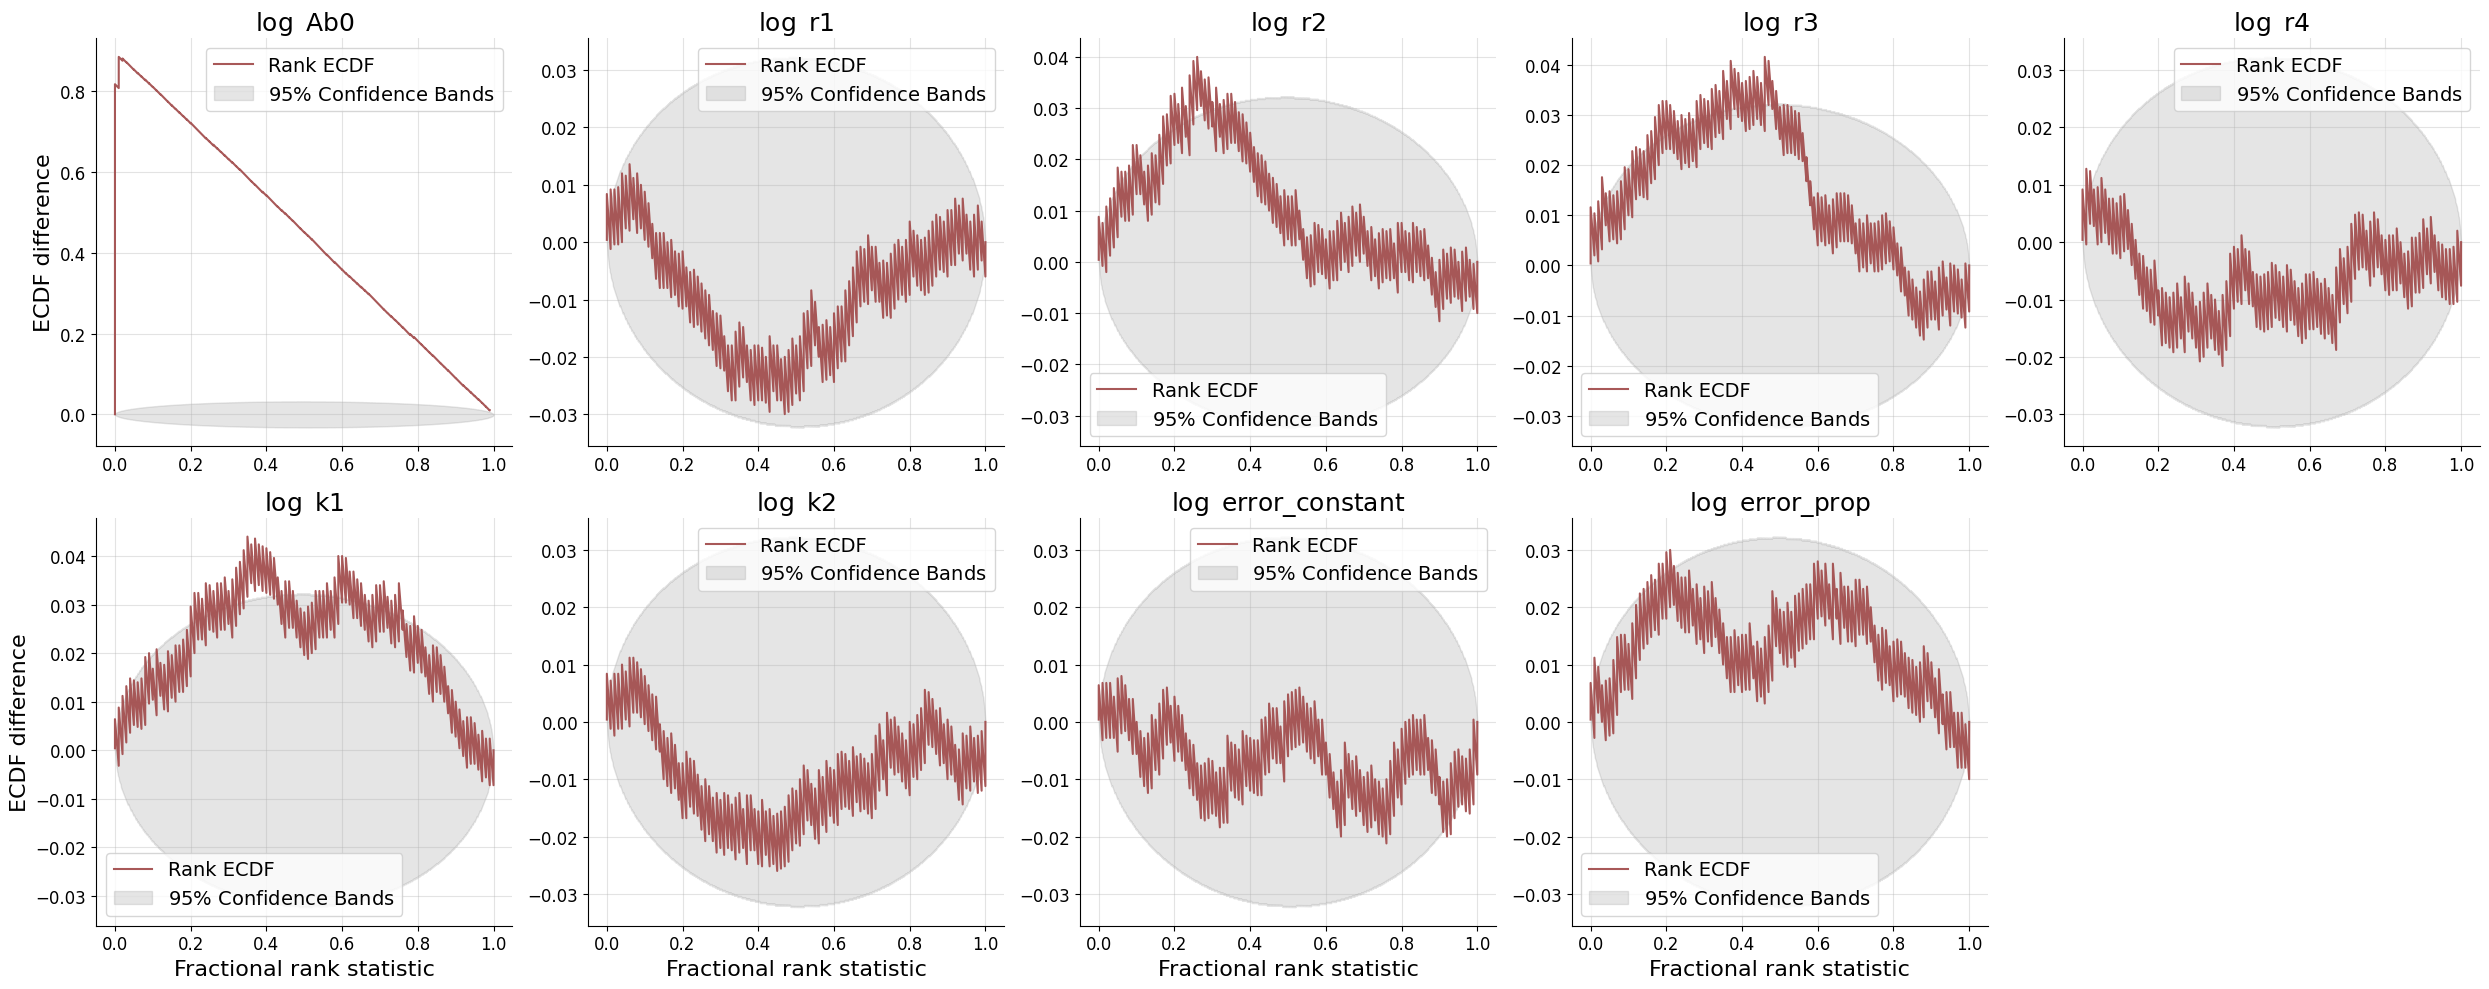

In [20]:
fig_ecdf_diff = diagnostics.plot_sbc_ecdf(post_samples=posterior_draws,
                                          prior_samples=new_sims['parameters'],
                                          difference=True,
                                          stacked=False,
                                          param_names=model.log_param_names)

if save_plots:
    fig_ecdf_diff.savefig(f'../plots/calibration/{model_name}/{model.network_name}_fig_ecdf_diff.png')

In [21]:
data_posterior_draws = model.draw_posterior_samples(data=test_data, n_samples=500)

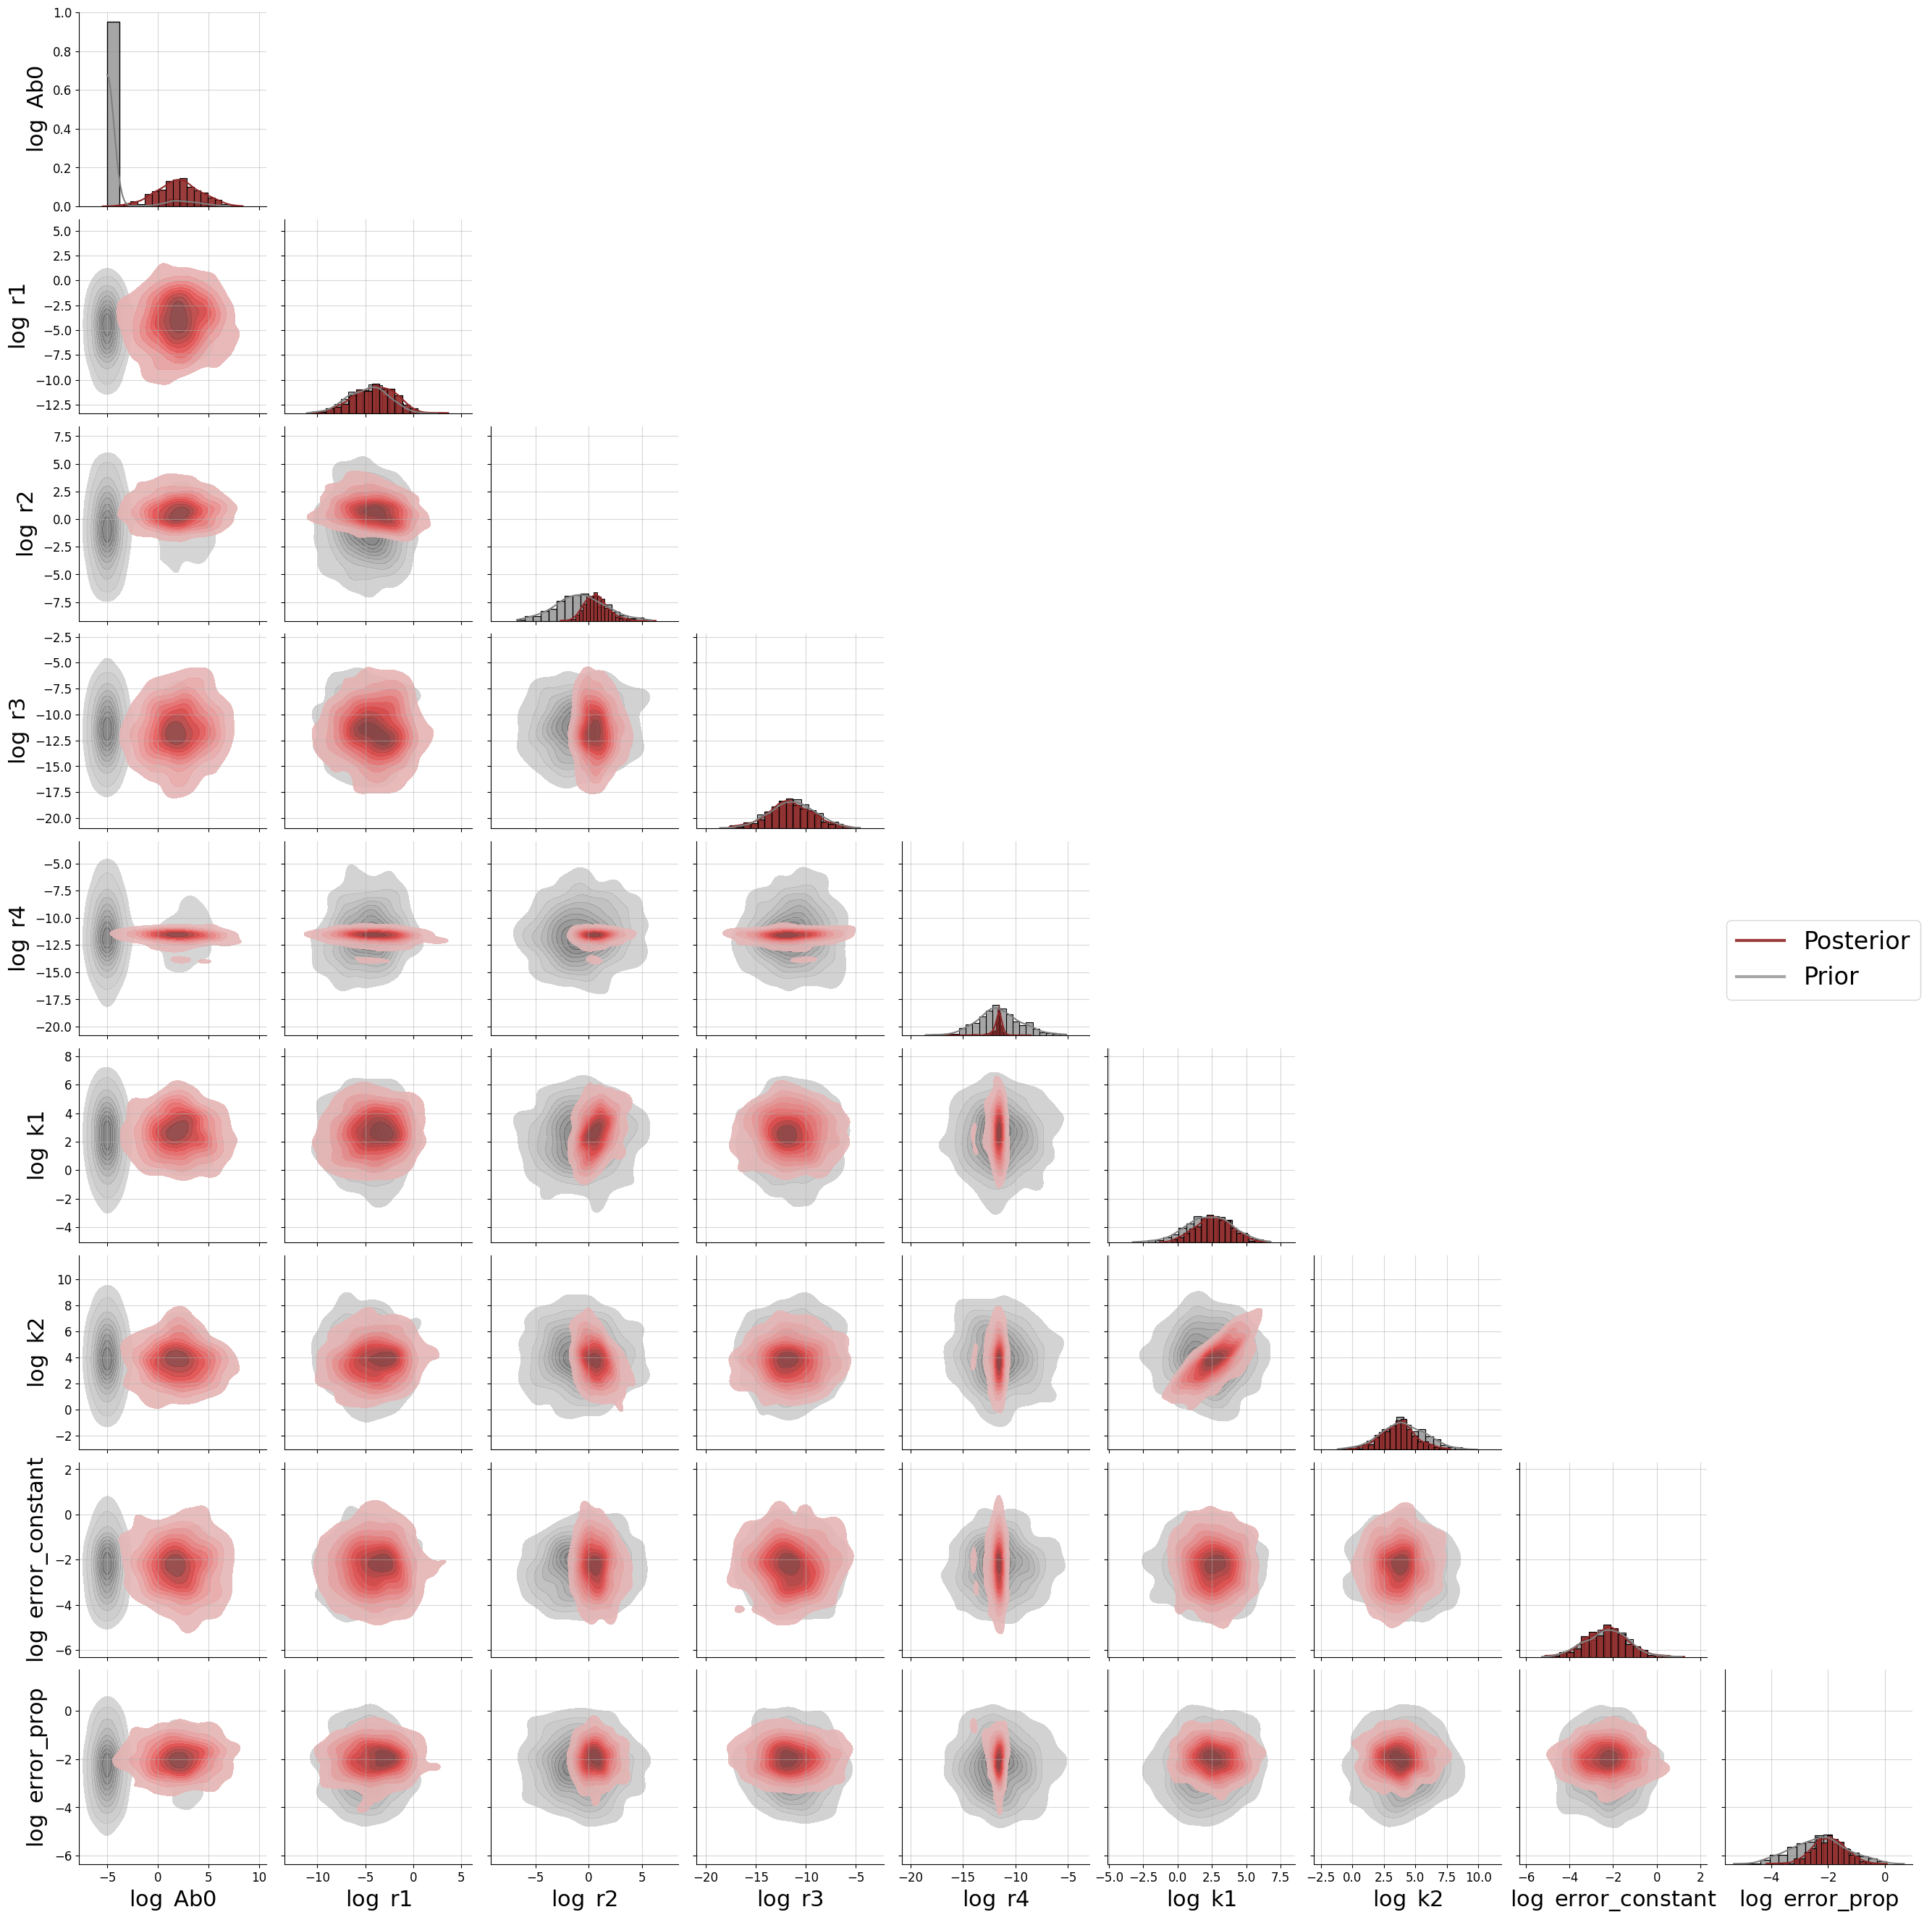

In [22]:
fig_posterior = diagnostics.plot_posterior_2d(posterior_draws=data_posterior_draws[0],
                                              prior=model.prior,
                                              label_fontsize=22,
                                              legend_fontsize=24,
                                              param_names=model.log_param_names)

if save_plots:
    fig_posterior.savefig(f'../plots/calibration/{model_name}/{model.network_name}_fig_posterior.png')